In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE

%matplotlib inline

Using TensorFlow backend.


## Load the MIMIC data

In [2]:
df = pd.read_csv('../data/UCI_train_test.csv')
df.drop(columns='Unnamed: 0',inplace=True)
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,change,diabetesMed,readmitted,tolbutamide,tolazamide,number_features_medications,diabetesMed_change,label
0,2278392,8222157,Caucasian,0,5,Unknown,unknown,referral,0.693147,41,...,No,No,No,No,NO,No,No,0,NoNo,0
1,28236,89869032,AfricanAmerican,0,45,Emergency,home,emergency_room,2.302585,47,...,Steady,No,No,Yes,>30,No,No,1,YesNo,0
2,590346,37746639,AfricanAmerican,0,45,Emergency,home_care,emergency_room,2.197225,55,...,Steady,No,No,Yes,>30,No,No,1,YesNo,0
3,630342,93232917,AfricanAmerican,0,55,Elective,home_care,referral,2.302585,37,...,Steady,No,No,Yes,>30,No,No,1,YesNo,0
4,676422,63754317,AfricanAmerican,0,75,Emergency,home,emergency_room,1.609438,48,...,Steady,No,No,Yes,>30,No,No,1,YesNo,0


In [3]:
df.shape

(5547, 37)

In [4]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted',
       'tolbutamide', 'tolazamide', 'number_features_medications',
       'diabetesMed_change', 'label'],
      dtype='object')

In [5]:
categorical_columns =['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                      'change', 'diabetesMed','diabetesMed_change']
features_medications = ['max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
       'glyburide-metformin', 'tolbutamide', 'tolazamide',]
numerical_columns = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications',
                     'number_outpatient', 'number_emergency','number_inpatient', 'number_diagnoses',
                    'number_features_medications',]


In [10]:
X = df[numerical_columns+categorical_columns]

In [14]:
X.shape

(5547, 36)

In [15]:
X.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,number_features_medications,...,admission_source_id_referral,admission_source_id_transfered,admission_source_id_unknown,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,diabetesMed_change_NoNo,diabetesMed_change_YesCh,diabetesMed_change_YesNo
0,5,0.693147,41,0,0.693147,0,0,0,1,0,...,1,0,0,0,1,1,0,1,0,0
1,45,2.302585,47,2,2.890372,0,0,0,9,1,...,0,0,0,0,1,0,1,0,0,1
2,45,2.197225,55,2,2.890372,0,0,0,9,1,...,0,0,0,0,1,0,1,0,0,1
3,55,2.302585,37,2,2.995732,0,0,1,4,1,...,1,0,0,0,1,0,1,0,0,1
4,75,1.609438,48,2,2.772589,0,1,0,9,1,...,0,0,0,0,1,0,1,0,0,1


In [13]:
X= pd.get_dummies(X, columns = ['race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                      'change', 'diabetesMed','diabetesMed_change'])

In [21]:
X_columns = list(X.columns)


In [22]:
y = df['label']
y.shape

(5547,)

## Prepare Balanced Data for Machine Learning

In [23]:
# The base line for this dataset
base = df['label'].value_counts(normalize=True)
print(f'The base line is\n{base}')

The base line is
0    0.907518
1    0.092482
Name: label, dtype: float64


In [24]:
# Split the train and test data

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42)

In [25]:
print(X_train.shape,X_test.shape)

(4160, 36) (1387, 36)


In [26]:
y.value_counts()

0    5034
1     513
Name: label, dtype: int64

In [27]:
y_train.value_counts(normalize=True)

0    0.908413
1    0.091587
Name: label, dtype: float64

In [28]:
y_test.value_counts(normalize=True)

0    0.904831
1    0.095169
Name: label, dtype: float64

In [29]:
# Banlance the train set with SMOTE
sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [30]:
print(X_train_sm.shape, y_train_sm.shape)
y_train_sm.value_counts(normalize=True)

(7558, 36) (7558,)


1    0.5
0    0.5
Name: label, dtype: float64

In [31]:
# Banlance the train set with SMOTE

X_test_sm, y_test_sm = sm.fit_sample(X_test, y_test)
print(X_test_sm.shape, y_test_sm.shape)
y_test_sm.value_counts(normalize=True)

(2510, 36) (2510,)


1    0.5
0    0.5
Name: label, dtype: float64

In [30]:
# StandardScaler
# sc = StandardScaler()
# X_train_sm_sc = sc.fit_transform(X_train_sm)
# X_test_sm_sc = sc.transform(X_test_sm)
# X_test_sc = sc.transform(X_test)

## Machine Learning Classification Models: Logistic Regression

In [18]:
model_lg = LogisticRegression()
model_lg.fit(X_train_sm, y_train_sm)

/Users/susanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
#cross_val_acc, train_acc, test_acc, sensitivity, specificity, precision, tp, fp 

In [60]:
model_lg = LogisticRegression()
cross_val_acc, train_acc, test_acc, sensitivity, specificity, precision, tp, fp = model_work(model_lg, 
                                                                                             X_train_tfidf,
                                                                                             y_train,
                                                                                             X_test_tfidf,
                                                                                             y_test)

/Users/susanchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


In [67]:
cross_val_acc, train_acc, test_acc, sensitivity, specificity, precision, tp, fp

(0.9177, 0.9255, 0.9229, 0.0, 0.990728476821192, 0.0, 0, 14)

## Machine Learning Classification Models: Random Forest

In [ ]:
# The unbalanced train and test test didn't work
# Try the balanced train set and didn't balanced test set

In [32]:
model_rf1 = RandomForestClassifier(n_estimators=50, max_depth=2)
model_rf1.fit(X_train_sm, y_train_sm)
cross_val_acc1 = round(cross_val_score(model_rf1, X_train_sm, y_train_sm).mean(),4)
train_acc1 = round(model_rf1.score(X_train_sm,y_train_sm),4)
test_acc1 = round(model_rf1.score(X_test,y_test),4)
preds1 = model_rf1.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds1).ravel()

In [33]:

print(f' cross_val_acc = {cross_val_acc1}\n train_acc = {train_acc1} \n test_acc = {test_acc1}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.7702
 train_acc = 0.7771 
 test_acc = 0.7231
 tn, fp, fn, tp (956, 299, 85, 47)


In [34]:
feature_importance_tup = sorted(zip(map(lambda x: round(x, 4), model_rf1.feature_importances_), numerical_columns), reverse=True)
feature_importance_tup[:30]

[(0.0963, 'time_in_hospital'),
 (0.0422, 'num_medications'),
 (0.0415, 'number_diagnoses'),
 (0.016, 'number_features_medications'),
 (0.0026, 'num_lab_procedures'),
 (0.0, 'number_outpatient'),
 (0.0, 'number_inpatient'),
 (0.0, 'number_emergency'),
 (0.0, 'num_procedures'),
 (0.0, 'age')]

In [ ]:
# Try the balanced train set and balanced test set

In [35]:
model_rf2 = RandomForestClassifier(n_estimators=50, max_depth=2)
model_rf2.fit(X_train_sm, y_train_sm)
cross_val_acc2 = round(cross_val_score(model_rf2, X_train_sm, y_train_sm).mean(),4)
train_acc2 = round(model_rf2.score(X_train_sm,y_train_sm),4)
test_acc2 = round(model_rf2.score(X_test_sm,y_test_sm),4)
preds2 = model_rf2.predict(X_test_sm)
tn, fp, fn, tp = confusion_matrix(y_test_sm, preds2).ravel()
print(f' cross_val_acc = {cross_val_acc2}\n train_acc = {train_acc2} \n test_acc = {test_acc2}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.7831
 train_acc = 0.7825 
 test_acc = 0.7821
 tn, fp, fn, tp (967, 288, 259, 996)


In [49]:
# rf = RandomForestClassifier()
# rf_params = {
#     'n_estimators':[25,50,100],
#     'max_depth':[3,4,5]
# }

# gs_rf = GridSearchCV(rf, 
#                      param_grid=rf_params,
#                      cv=5)

# gs_rf.fit(X_train_cvec, y_train)

In [50]:
# print(gs_rf.best_score_)
# print(gs_rf.best_params_)
# print(gs_rf.score(X_test_cvec, y_test))

## Machine Learning Classification Models: XG Boost

In [ ]:
# The unbalanced train and test test didn't work
# Try the balanced train set and didn't balanced test set

In [36]:
model_xg1 = XGBClassifier()
model_xg1.fit(X_train_sm, y_train_sm)
cross_val_acc3 = round(cross_val_score(model_xg1, X_train_sm, y_train_sm).mean(),4)
train_acc3 = round(model_xg1.score(X_train_sm,y_train_sm),4)
test_acc3 = round(model_xg1.score(X_test,y_test),4)
preds3 = model_xg1.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds3).ravel()

In [37]:
print(f' cross_val_acc = {cross_val_acc3}\n train_acc = {train_acc3} \n test_acc = {test_acc3}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.927
 train_acc = 0.9337 
 test_acc = 0.8962
 tn, fp, fn, tp (1242, 13, 131, 1)


In [38]:
feature_importance_xg = sorted(zip(map(lambda x: round(x, 4), model_xg1.feature_importances_), X_columns), reverse=True)
feature_importance_xg[:15]

[(0.1022, 'admission_type_id_Elective'),
 (0.0894, 'change_Ch'),
 (0.0773, 'diabetesMed_No'),
 (0.0654, 'discharge_disposition_id_home_care'),
 (0.0654, 'change_No'),
 (0.0558, 'discharge_disposition_id_home'),
 (0.0452, 'admission_type_id_Emergency'),
 (0.0449, 'admission_source_id_referral'),
 (0.0416, 'discharge_disposition_id_transferred'),
 (0.0404, 'race_Caucasian'),
 (0.0377, 'race_AfricanAmerican'),
 (0.0371, 'gender'),
 (0.0354, 'discharge_disposition_id_unknown'),
 (0.0351, 'diabetesMed_Yes'),
 (0.0312, 'admission_type_id_Unknown')]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


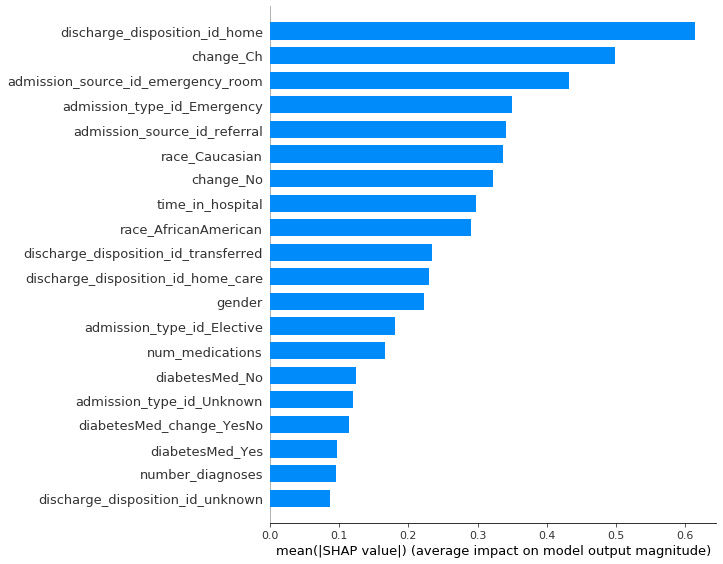

In [44]:
import shap
shap_values = shap.TreeExplainer(model_xg2).shap_values(X_train_sm)
shap.summary_plot(shap_values, X_train_sm, plot_type="bar", feature_names=X_columns)

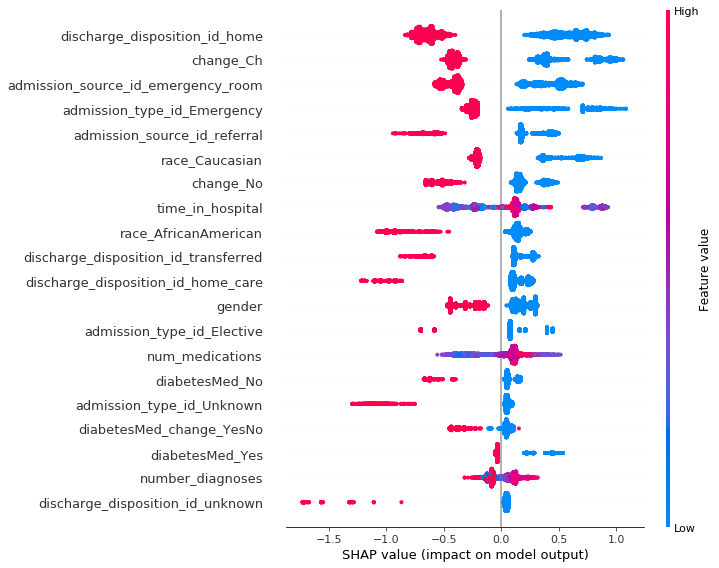

In [45]:
shap.summary_plot(shap_values, X_train_sm,feature_names=X_columns)

In [43]:
model_xg2 = XGBClassifier()
model_xg2.fit(X_train_sm, y_train_sm)
cross_val_acc4 = round(cross_val_score(model_xg2, X_train_sm, y_train_sm).mean(),4)
train_acc4 = round(model_xg2.score(X_train_sm,y_train_sm),4)
test_acc4 = round(model_xg2.score(X_test_sm,y_test_sm),4)
preds4 = model_xg2.predict(X_test_sm)
tn, fp, fn, tp = confusion_matrix(y_test_sm, preds2).ravel()
print(f' cross_val_acc = {cross_val_acc4}\n train_acc = {train_acc4} \n test_acc = {test_acc4}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.927
 train_acc = 0.9337 
 test_acc = 0.9303
 tn, fp, fn, tp (967, 288, 259, 996)


## Machine Learning Classification Models: SVM

In [ ]:
# The unbalanced train and test test didn't work
# Try the balanced train set and didn't balanced test set

In [48]:
svc1 =SVC(gamma = 'scale', random_state=42)
svc1.fit(X_train_sm, y_train_sm)

y_pred1 = svc1.predict(X_test_sm)
accuracy_score(y_test_sm, y_pred1)

0.5828685258964144

In [50]:
tn, fp, fn, tp = confusion_matrix(y_test_sm,y_pred1).ravel()
tn, fp, fn, tp

(482, 773, 274, 981)

## Machine Learning Classification Models: FFNN(feed forward neutral network)

In [51]:
n_input = X_train_sm.shape[1]
n_input

10

In [53]:
model_ffnn = Sequential()

lam=0.09
model_ffnn.add(Dense(n_input,
                   input_dim = n_input,
                   activation = 'relu',
                   kernel_regularizer = regularizers.l2(lam)
                       ))
model_dropout = Sequential()
model_dropout.add(Dropout(0.5))
model_ffnn.add(Dense(1,
                   activation='sigmoid'))

model_ffnn.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta=0, 
                           patience=5,
                           mode='auto')
history_all = model_ffnn.fit(X_train_sm,
                          y_train_sm,
                          validation_data=(X_test_sm,y_test_sm),
                          epochs=10,
                          batch_size=None,
                          verbose=2,
                          callbacks=[early_stop]
                          )

Train on 7558 samples, validate on 2510 samples
Epoch 1/10
 - 1s - loss: 1.6479 - acc: 0.5030 - val_loss: 1.0633 - val_acc: 0.5382
Epoch 2/10
 - 0s - loss: 0.9455 - acc: 0.5261 - val_loss: 0.8489 - val_acc: 0.5390
Epoch 3/10
 - 0s - loss: 0.8123 - acc: 0.5406 - val_loss: 0.7744 - val_acc: 0.5717
Epoch 4/10
 - 0s - loss: 0.7634 - acc: 0.5564 - val_loss: 0.7414 - val_acc: 0.5745
Epoch 5/10
 - 0s - loss: 0.7415 - acc: 0.5635 - val_loss: 0.7303 - val_acc: 0.5797
Epoch 6/10
 - 0s - loss: 0.7306 - acc: 0.5609 - val_loss: 0.7211 - val_acc: 0.5932
Epoch 7/10
 - 0s - loss: 0.7213 - acc: 0.5732 - val_loss: 0.7256 - val_acc: 0.5514
Epoch 8/10
 - 0s - loss: 0.7147 - acc: 0.5789 - val_loss: 0.7110 - val_acc: 0.5749
Epoch 9/10
 - 0s - loss: 0.7112 - acc: 0.5725 - val_loss: 0.7249 - val_acc: 0.5355
Epoch 10/10
 - 0s - loss: 0.7078 - acc: 0.5728 - val_loss: 0.7023 - val_acc: 0.5578


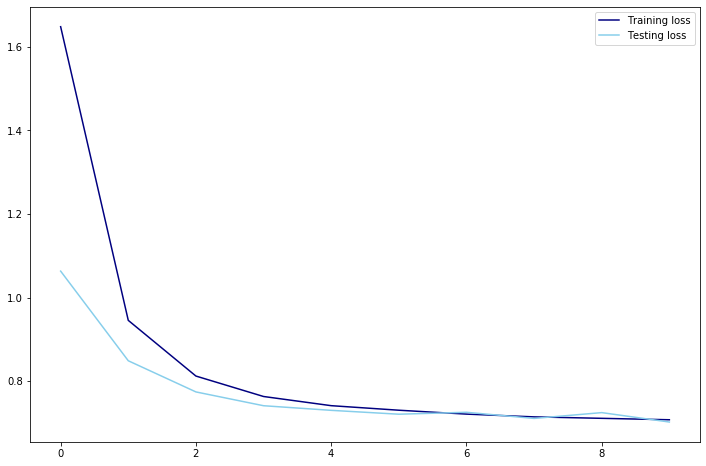

In [54]:
train_loss_all = history_all.history['loss']
test_loss_all = history_all.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss_all, label='Training loss', color='navy')
plt.plot(test_loss_all, label='Testing loss', color='skyblue')
plt.legend();

In [55]:
history_all.history['acc'][-1], history_all.history['val_acc'][-1]

(0.5727706, 0.5577689409255981)